# Submission Project ML Intermediate 2
* Nama : Ferdy Rizkiawan
* Email : ferdyrizkiawan@student.uns.ac.id
* ID Dicoding : ferdyrizz

### Beberapa hal yang dicapai:
1. Dataset memiliki lebih dari 10rb data
2. Mengimplementasikan callback
3. Mae dan Val Mae di bawah treshold
4. Membuat plot mae dan loss dari train dan test
5. Membuat plot pembagian train dan test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM
from keras.regularizers import l2

In [36]:
df = pd.read_csv('traffic.csv')
df = df.drop(columns=['Junction', 'ID'])
df = df[df.index < 11000]
df

,DateTime,Vehicles
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9
...,...,...
10995,2017-02-01 03:00:00,48
10996,2017-02-01 04:00:00,45
10997,2017-02-01 05:00:00,36
10998,2017-02-01 06:00:00,39


In [37]:
min_max_scaler = MinMaxScaler()
df['Vehicles'] = min_max_scaler.fit_transform(df['Vehicles'].values.reshape(-1,1))

In [38]:
hours = df.index.values
freq = df['Vehicles'].values

freq_train, freq_test, hours_train, hours_test = train_test_split(freq, hours, test_size=0.2, shuffle=False)

Total data train: 8800
Total data test: 2200


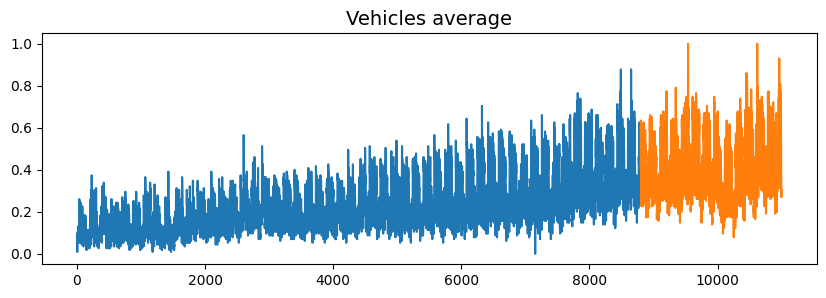

In [39]:
print('Total data train:', len(freq_train))
print('Total data test:', len(freq_test))

plt.figure(figsize=(10, 3))
plt.plot(hours_train, freq_train)
plt.plot(hours_test, freq_test)
plt.title('Vehicles average', fontsize=14)
plt.show()

In [40]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [56]:
train_set = windowed_dataset(freq_train, window_size=100, batch_size=200, shuffle_buffer=1000)
test_set = windowed_dataset(freq_test, window_size=100, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
])

In [57]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1.0000e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

treshold = 0.1 * (df['Vehicles'].max() - df['Vehicles'].min())
treshold

0.1

In [58]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < treshold and logs.get('val_mae') < treshold):
            print("\nMAE telah mencapai treshold!")
            self.model.stop_training = True

callbacks = myCallback()

hist = model.fit(
    train_set,
    validation_data=test_set,
    epochs=100,
    batch_size=128,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
44/44 - 9s - loss: 0.0338 - mae: 0.2254 - val_loss: 0.0495 - val_mae: 0.2753 - 9s/epoch - 206ms/step
Epoch 2/100
44/44 - 5s - loss: 0.0227 - mae: 0.1682 - val_loss: 0.0310 - val_mae: 0.2040 - 5s/epoch - 103ms/step
Epoch 3/100
44/44 - 3s - loss: 0.0211 - mae: 0.1615 - val_loss: 0.0305 - val_mae: 0.2022 - 3s/epoch - 60ms/step
Epoch 4/100
44/44 - 3s - loss: 0.0196 - mae: 0.1542 - val_loss: 0.0298 - val_mae: 0.1999 - 3s/epoch - 60ms/step
Epoch 5/100
44/44 - 3s - loss: 0.0185 - mae: 0.1500 - val_loss: 0.0283 - val_mae: 0.1941 - 3s/epoch - 61ms/step
Epoch 6/100
44/44 - 2s - loss: 0.0176 - mae: 0.1463 - val_loss: 0.0264 - val_mae: 0.1866 - 2s/epoch - 56ms/step
Epoch 7/100
44/44 - 3s - loss: 0.0174 - mae: 0.1436 - val_loss: 0.0264 - val_mae: 0.1870 - 3s/epoch - 61ms/step
Epoch 8/100
44/44 - 4s - loss: 0.0164 - mae: 0.1396 - val_loss: 0.0246 - val_mae: 0.1798 - 4s/epoch - 93ms/step
Epoch 9/100
44/44 - 3s - loss: 0.0156 - mae: 0.1355 - val_loss: 0.0233 - val_mae: 0.1746 - 3s/epoch - 

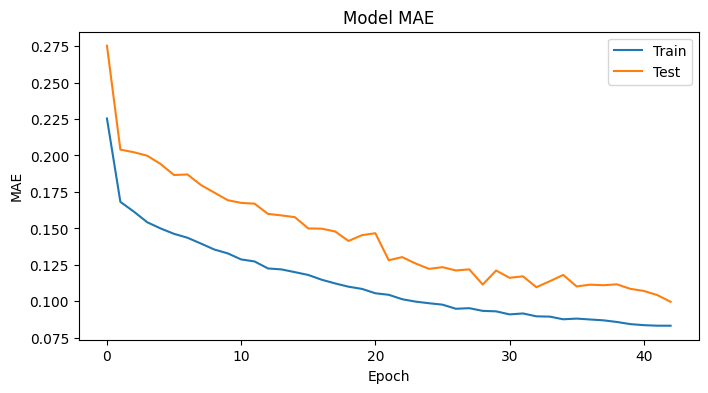

In [59]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title("Model MAE")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])
plt.show()

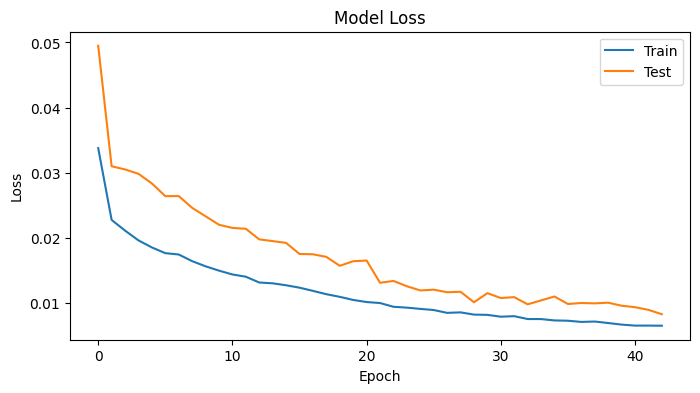

In [60]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Test'])
plt.show()